# Crosscorrelation functions in a 2D homogeneous acoustic medium

This script demonstrate the cross-correlation functions at two receivers from ambient noise sources in a 2D homogeneous acoustic medium. It also applies to single-frequency surface waves on the Earth's surface.

Author: Yunyue Elita Li, elitali@purdue.edu

Date: Nov 20, 2024

Key parameters to play with:
1. Number of random sources
2. Range of source angles
3. Source signature:
  - Impulsive source with Ricker wavelet
  - Random source (long duration) with flat spectrum
  - Random source (long duration) with Ricker spectrum

Key observations:
1. When the noise sources are impulsive
  - Direct waves are well reconstructed in the stacked XCF
  - Insufficient destructive summation results in artifacts arriving earlier than the direct waves
2. When the noise sources are continuous (long duration)
  - Direct waves are still well constructed in the stacked XCF
  - Source crosstalks show up both before and after direct wave arrivals

In [1]:
# Import all necessary librarys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.signal import convolve, correlate

In [2]:
# Set the parameters to test

# number of sources
nsources = 1000

# random angles of the plane waves
angles = np.random.uniform(0, 2*np.pi, nsources)
# sort the angles from low to high
angles = np.sort(angles)

# random times of the plane waves
times = np.random.randn(nsources)

# define the locations of two receivers [x,y] in meters
receiver1 = np.array([100, 0])
receiver2 = np.array([500, 0])

# set the velocity of the medium m/s
vel = 400

# source parameters
central_frequency = 25  # Hz, for ricker wavelet

# flag to turn on the band limit of random sources
bndlmt_randsrc = 1

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/EAPS 591 Fall 2024/Modules')

from corrplot import *


# prompt: for each angle and time pair, calculate the arrival time at the two stations using the following equation t1 = x1/v*sin(angle) + time

arrival_times_station1 = []
arrival_times_station2 = []

for angle, time in zip(angles, times):
  t1 = receiver1[0] / vel * np.sin(angle) + receiver1[1] / vel * np.cos(angle) + time
  t2 = receiver2[0] / vel * np.sin(angle) + receiver2[1] / vel * np.cos(angle) + time
  arrival_times_station1.append(t1)
  arrival_times_station2.append(t2)

max_arrival_time_station1 = max(np.abs(arrival_times_station1))
max_arrival_time_station2 = max(np.abs(arrival_times_station2))

max_time = max(max_arrival_time_station1,max_arrival_time_station2)*1.02;

# define the passive acquisition
dt = 1e-3
taxis = np.arange(-max_time,max_time,dt)

record1 = np.zeros([len(taxis),len(angles)])
record2 = np.zeros([len(taxis),len(angles)])

Mounted at /content/drive


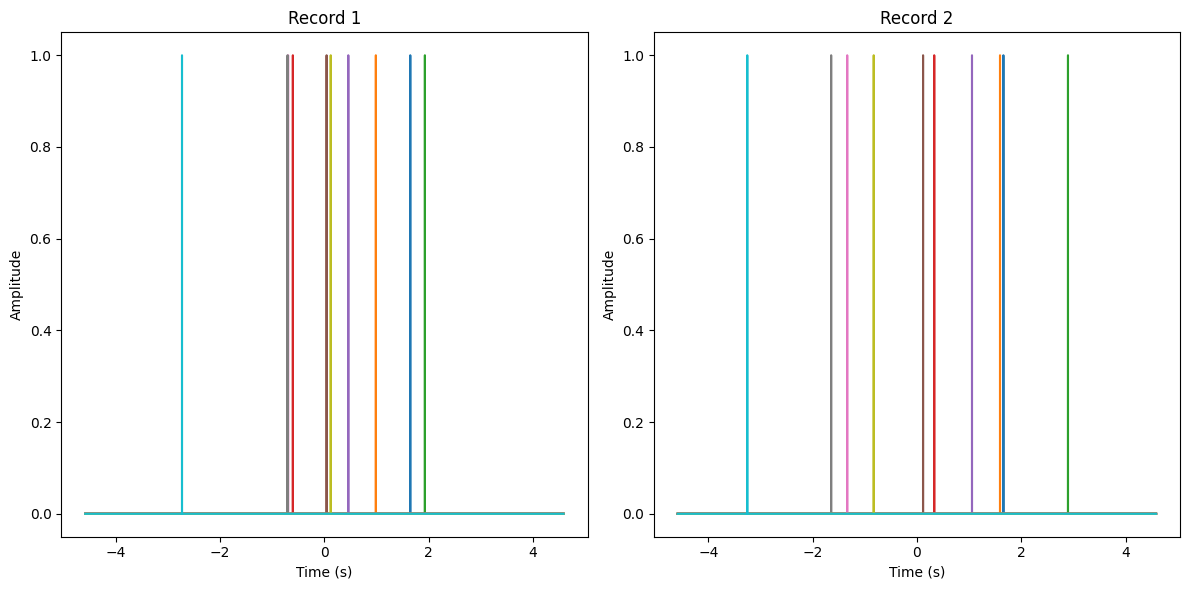

In [4]:
# prompt: for each angle, find place 1 at the arrival times for each station

for angle_index, (t1, t2) in enumerate(zip(arrival_times_station1, arrival_times_station2)):
  time_index_station1 = int((t1-taxis[0]) / dt)
  time_index_station2 = int((t2-taxis[0]) / dt)

  if 0 <= time_index_station1 < len(taxis):
    record1[time_index_station1, angle_index] = 1
  if 0 <= time_index_station2 < len(taxis):
    record2[time_index_station2, angle_index] = 1

plot_records(record1, record2, taxis, plotN=100)

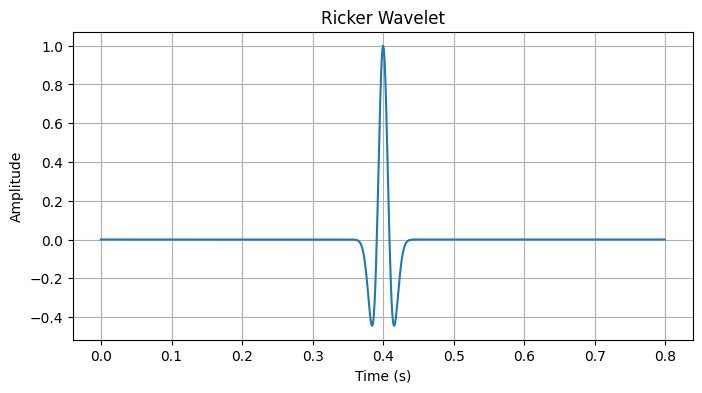

In [5]:
# Generate a ricker wavelet:
sampling_interval = dt
wavelet_length = 0.8  # seconds

ricker = ricker_wavelet(central_frequency, sampling_interval, wavelet_length)

# Plot the Ricker wavelet
plt.figure(figsize=(8, 4))
plt.plot(np.arange(0, len(ricker)) * sampling_interval, ricker)
plt.title('Ricker Wavelet')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

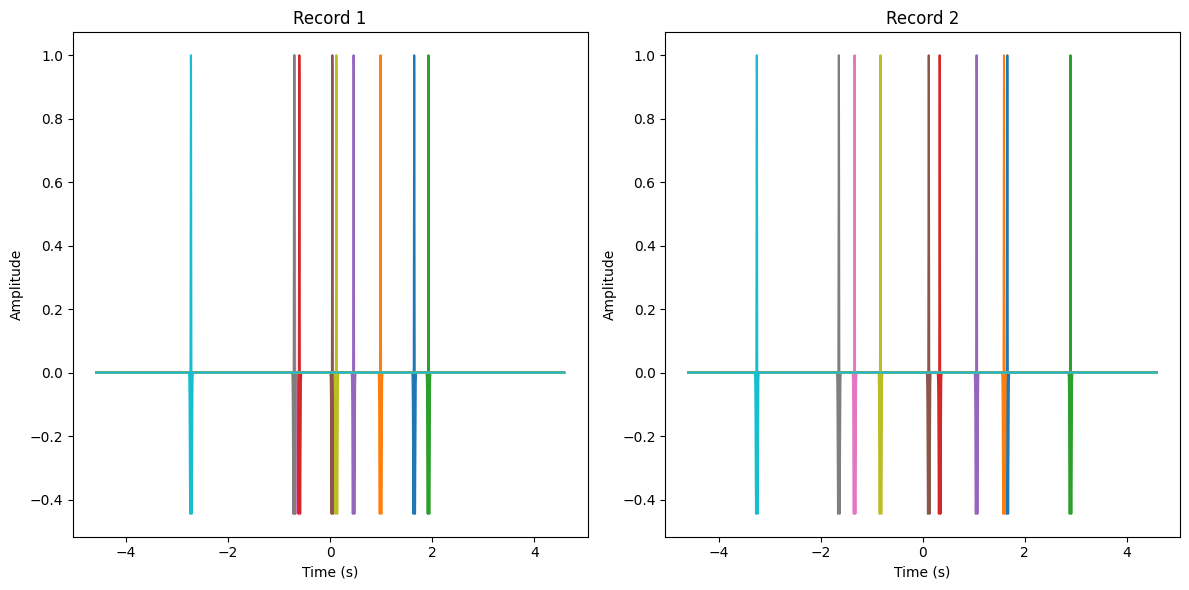

In [6]:
# Convolve record1 and record2 with the Ricker wavelet
convolved_record1 = np.zeros_like(record1)
convolved_record2 = np.zeros_like(record2)

for i in range(record1.shape[1]):
    convolved_record1[:, i] = convolve(record1[:, i], ricker, mode='same')
    convolved_record2[:, i] = convolve(record2[:, i], ricker, mode='same')

plot_records(convolved_record1, convolved_record2, taxis, plotN=100)

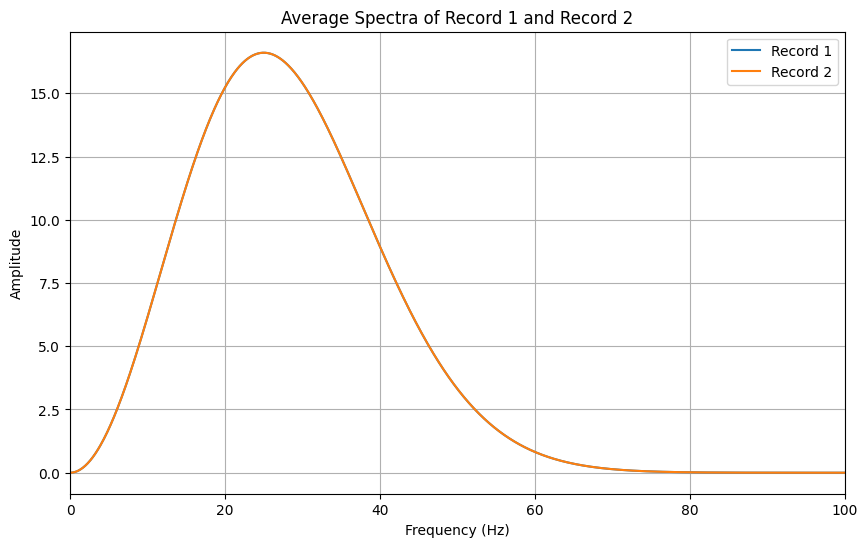

In [7]:
# prompt: plot the average spectra of record 1 and record 2

plot_average_spectra(convolved_record1, convolved_record2, taxis, fmin=0, fmax=100)

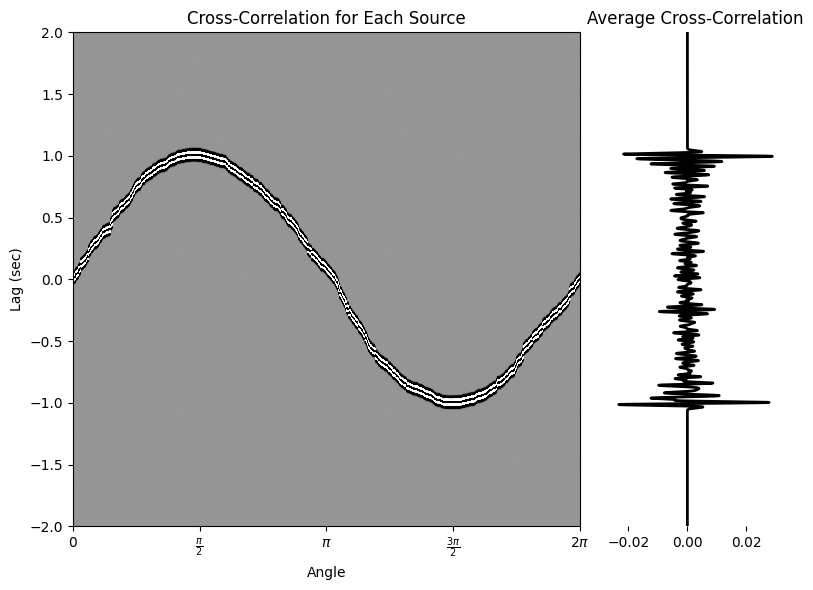

In [8]:
# prompt: for each angle, cross-correlate the convolved record1 and record2,
epsilon = 1e-6
# Calculate cross-correlation for each angle
cross_correlations = []
for i in range(convolved_record1.shape[1]):
  correlation = correlate(convolved_record1[:, i], convolved_record2[:, i], mode='full')
  correlation /= np.max(np.abs(correlation)+epsilon)
  cross_correlations.append(correlation)

# Convert the list of cross-correlations to a NumPy array
cross_correlations_array = np.transpose(np.array(cross_correlations))
# Calculate the average cross-correlation across all angles
average_cross_correlation = np.mean(cross_correlations_array, axis=1)

# Plot the cross-correlations
plot_cross_correlations(cross_correlations_array, angles, dt, maxlag=2, clippc=0.5, savefig=False)

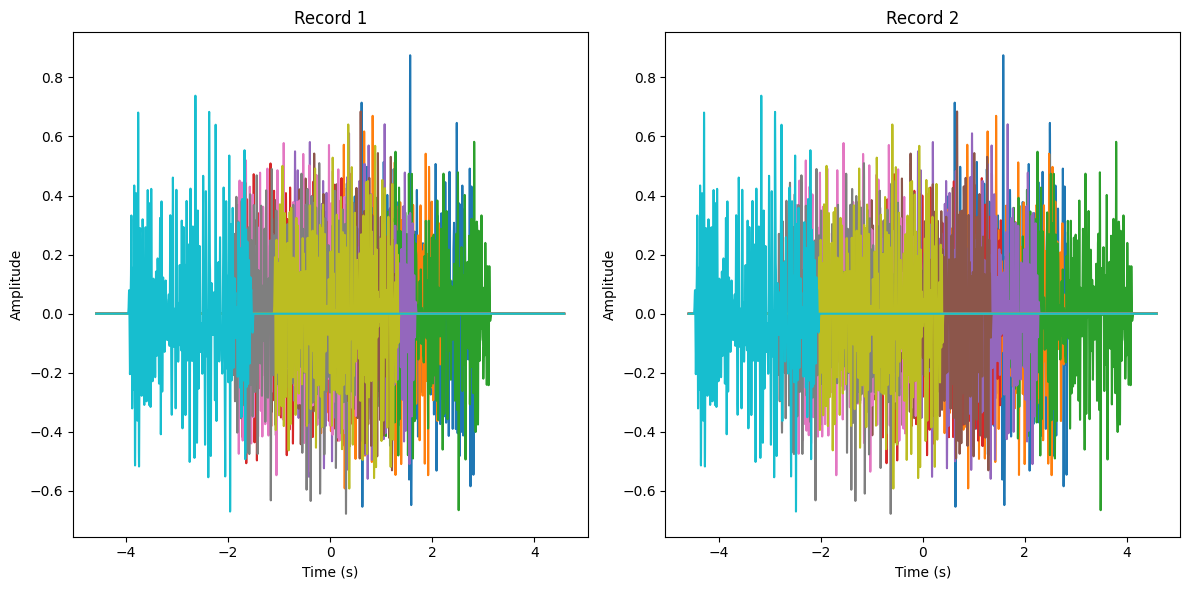

In [9]:
# Convolve convolved_record1 and convolved_record2 with random numbers

convolved_record1_random = np.zeros_like(convolved_record1)
convolved_record2_random = np.zeros_like(convolved_record2)

for i in range(convolved_record1.shape[1]):
    random_noise = np.random.randn(3*len(ricker))  # Generate random noise
    if bndlmt_randsrc == 1:
      convolved_record1_random[:, i] = convolve(convolved_record1[:, i], random_noise, mode='same')
      convolved_record2_random[:, i] = convolve(convolved_record2[:, i], random_noise, mode='same')
    else:
      convolved_record1_random[:, i] = convolve(record1[:, i], random_noise, mode='same')
      convolved_record2_random[:, i] = convolve(record2[:, i], random_noise, mode='same')

# Normalize the correlated records
convolved_record1_random /= np.max(np.abs(convolved_record1_random))
convolved_record2_random /= np.max(np.abs(convolved_record2_random))

plot_records(convolved_record1_random, convolved_record2_random, taxis, plotN=100)

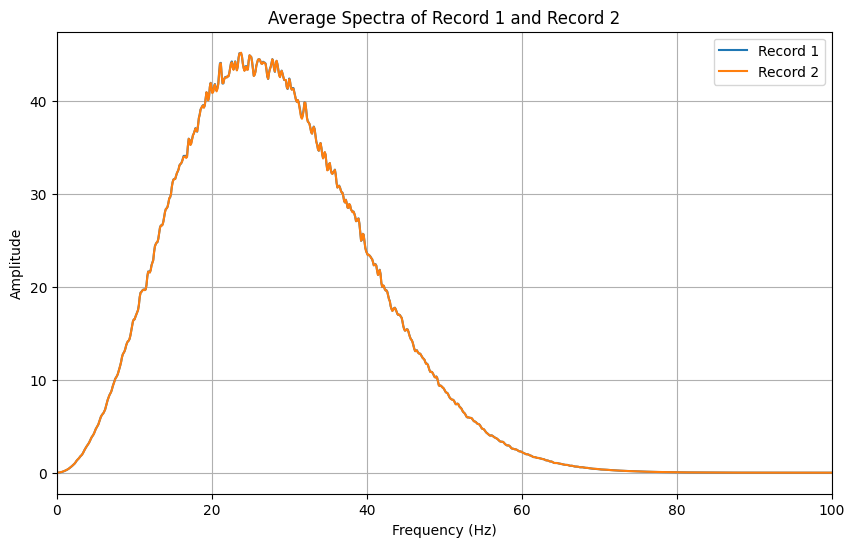

In [10]:
# Plot the averages spectrum of the random source recordings
plot_average_spectra(convolved_record1_random, convolved_record2_random, taxis, fmin=0, fmax=100)

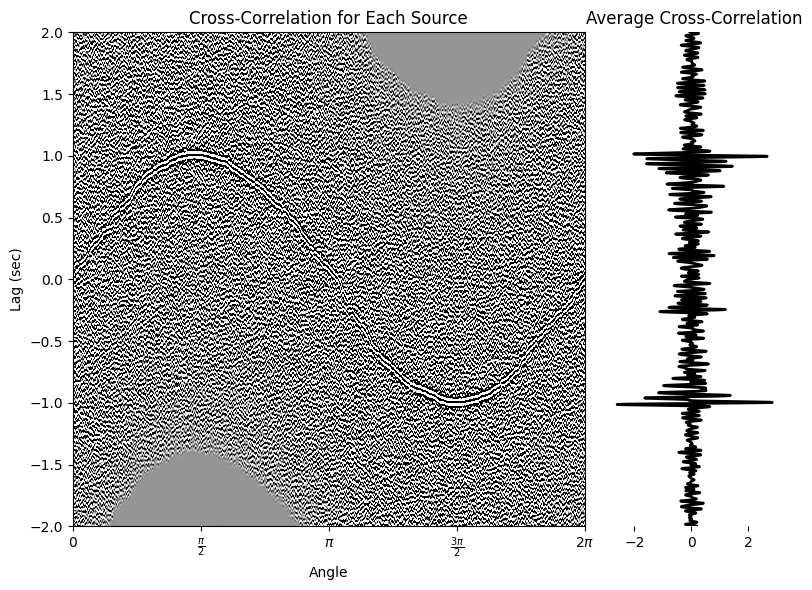

In [11]:
# prompt: cross-correlate the convolved_record1_random and convolved_record2_random

# Calculate cross-correlation for each angle for the randomly convolved records
cross_correlations_random = []
for i in range(convolved_record1_random.shape[1]):
    correlation_random = correlate(convolved_record1_random[:, i], convolved_record2_random[:, i], mode='full')
    cross_correlations_random.append(correlation_random)


# Convert the list of cross-correlations to a NumPy array
cross_correlations_random_array = np.transpose(np.array(cross_correlations_random))

# Calculate the average cross-correlation across all angles for the randomly convolved records
average_cross_correlation_random = np.mean(cross_correlations_random_array, axis=1)

# plot the cross-correlations
plot_cross_correlations(cross_correlations_random_array, angles, dt, maxlag=2, clippc=0.5, savefig=False)

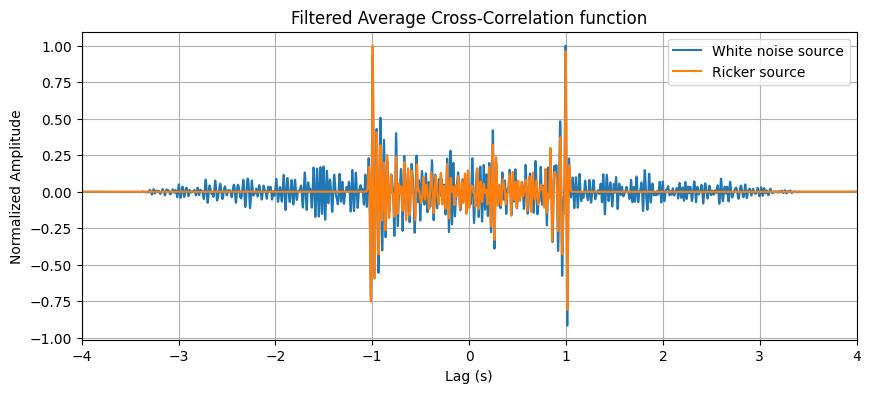

In [12]:
# prompt: filter the average_cross_correlation_random between 1 and 50 Hz, and plot the filtered signal in time

from scipy.signal import butter, filtfilt

# Define the filter parameters
lowcut = 2  # Lower cutoff frequency (Hz)
highcut = 100  # Upper cutoff frequency (Hz)
fs = 1 / dt  # Sampling frequency (Hz)

# Create a bandpass filter
b, a = butter(4, [lowcut, highcut], btype='bandpass', fs=fs)

# Apply the filter to the average cross-correlation
filtered_average_cross_correlation_random = filtfilt(b, a, average_cross_correlation_random)
filtered_average_cross_correlation_random /= np.max(np.abs(filtered_average_cross_correlation_random))

# filter and normalize the average cross-correlation function
filtered_average_cross_correlation = filtfilt(b, a, average_cross_correlation)
filtered_average_cross_correlation /= np.max(np.abs(filtered_average_cross_correlation))

# Plot the filtered signal in time
plt.figure(figsize=(10, 4))
lag_axis = np.arange(-len(average_cross_correlation_random) // 2, len(average_cross_correlation_random) // 2) * dt
plt.plot(lag_axis, filtered_average_cross_correlation_random, label='White noise source')
plt.plot(lag_axis, filtered_average_cross_correlation, '-', label='Ricker source')
plt.xlim(-4, 4)
plt.xlabel('Lag (s)')
plt.ylabel('Normalized Amplitude')
plt.title('Filtered Average Cross-Correlation function')
plt.grid(True)
plt.legend()
plt.show()